<a href="https://colab.research.google.com/github/nezhablack/project1/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D0%BF%D0%BE_%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8E_%D0%BB%D0%B5%D1%81%D0%BD%D1%8B%D1%85_%D0%BF%D0%BE%D0%B6%D0%B0%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение лесных пожаров по спутниковым снимкам с помощью CNN

---

## Блок 1. Описание задачи

В этом ноутбуке решается задача бинарной классификации изображений: есть ли на спутниковом снимке пожар (класс "fire") или нет (класс "no_fire").

Используется датасет **Wildfire Prediction Dataset (Satellite Images)** с Kaggle, содержащий спутниковые изображения регионов с пожарами и без.  
Модель: сверточная нейронная сеть (CNN), обученная различать эти два класса.


# Блок 2. Установка и импорт библиотек

In [52]:
!pip install -q kaggle

import os, json, zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Фиксируем зерно для воспроизводимости
tf.random.set_seed(42)
np.random.seed(42)



# Блок 3. Пути к данным и базовые параметры

In [26]:
# в последующих двух ячейках скачиваю датасет с kaggle, в реальном продукте это будут другие источники спутниковых снимков специально для пожарных служб
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset -p /content


Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
100% 1.44G/1.45G [00:16<00:00, 94.9MB/s]
100% 1.45G/1.45G [00:16<00:00, 92.6MB/s]


In [34]:
zip_path = "/content/wildfire-prediction-dataset.zip"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall("/content")

!ls /content


drive		 sample_data  train  wildfire-prediction-dataset.zip
forestfires.csv  test	      valid


In [53]:
train_dir = "/content/train"
val_dir = "/content/valid"
test_dir = "/content/test"

# Размер входного изображения для модели (подбирается под датасет и ресурсы)
img_height = 128
img_width = 128
batch_size = 32


# Блок 4. Подготовка генераторов данных (Data Augmentation)




In [54]:
# Для обучающей выборки добавляем аугментации (случайные повороты, сдвиги и т.п.)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Для валидации и теста используем рескейл, чтобы на вход сеть подавался маленький и стабильный масштаб.
# Так сеть лучше обучается
test_datagen = ImageDataGenerator(rescale=1./255)

img_height = 32
img_width = 32

# Создаем генераторы, которые будут читать изображения из папок и подавать в модель
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary"
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print("Классы (метки):", train_generator.class_indices)


Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Классы (метки): {'nowildfire': 0, 'wildfire': 1}


# Блок 5. Визуализация нескольких примеров изображений


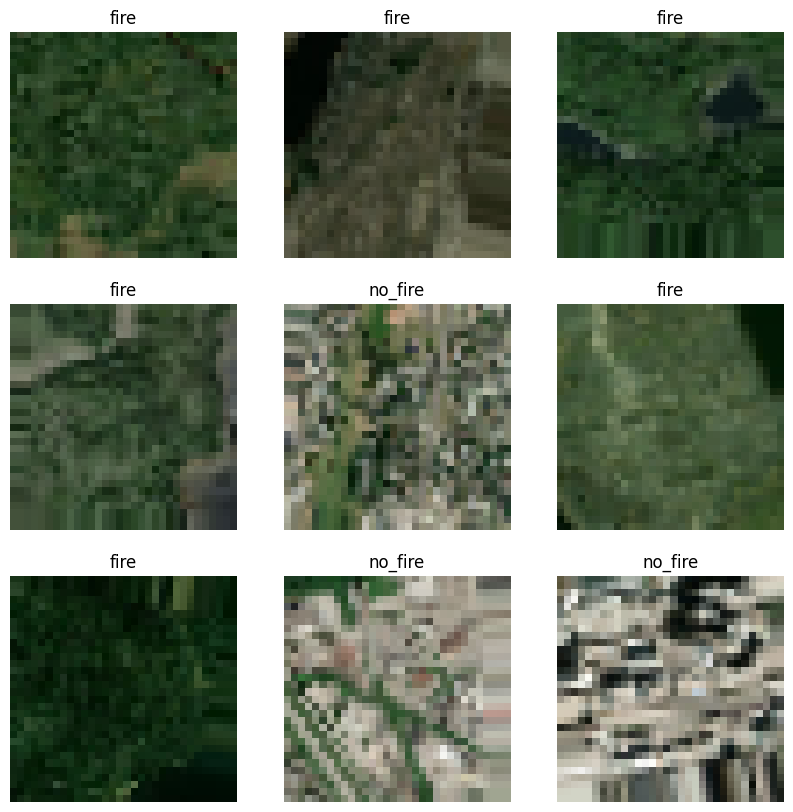

In [55]:
#В проекте размер спутниковых снимков был уменьшен, чтобы ускорить модель. Это привело к потере качества.
#В реальных проектах, если важно качество, можно увеличить размеры получаемых снимков до приемлемой детализации
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    label = "fire" if labels[i] == 1 else "no_fire"
    plt.title(label)
plt.show()


# Блок 6. Определение упрощённой CNN-модели (на основе Kaggle-решения)


In [56]:
img_height = 32
img_width = 32

model = Sequential([
    # Часть 1: простые признаки
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Часть 2: более сложные контуры и текстуры
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Часть 3: ещё чуть глубже, но без перегиба
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Переход к полносвязной части
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")  # выход: вероятность "fire"
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,153 (3.21 MB)

 Trainable params: 840,257 (3.21 MB)

 Non-trainable params: 896 (3.50 KB)

# Блок 7. Обучение модели

In [57]:
#Здесь обучение небольшим количеством эпох дало устойчивый результат и достаточно высокую точность
epochs = 5

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


Epoch 1/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 578s 606ms/step - accuracy: 0.8838 - loss: 0.3255 - val_accuracy: 0.5652 - val_loss: 0.8321
Epoch 2/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 559s 591ms/step - accuracy: 0.9198 - loss: 0.2115 - val_accuracy: 0.8521 - val_loss: 0.3693
Epoch 3/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 560s 591ms/step - accuracy: 0.9303 - loss: 0.1862 - val_accuracy: 0.8302 - val_loss: 0.5058
Epoch 4/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 571s 604ms/step - accuracy: 0.9360 - loss: 0.1697 - val_accuracy: 0.7724 - val_loss: 0.5681
Epoch 5/5
946/946 ━━━━━━━━━━━━━━━━━━━━ 559s 591ms/step - accuracy: 0.9368 - loss: 0.1665 - val_accuracy: 0.9114 - val_loss: 0.2399


# Блок 8. Графики обучения (loss и accuracy)

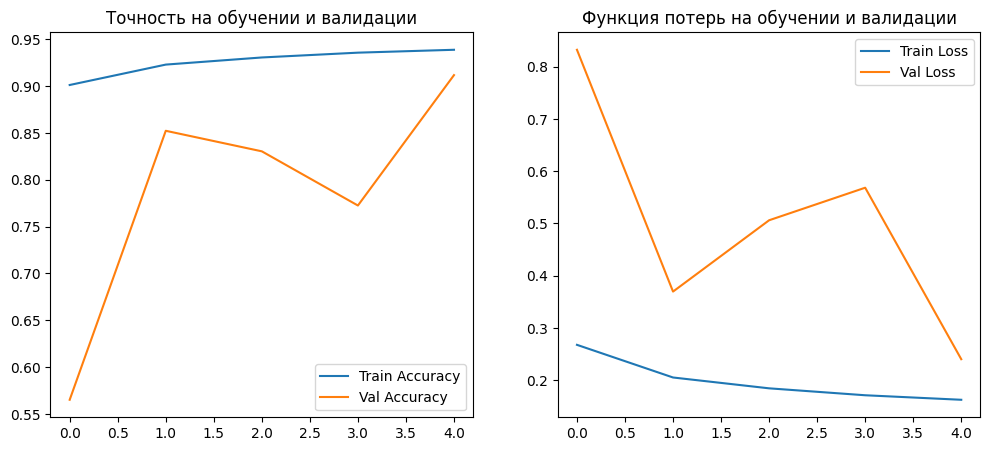

In [58]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend(loc="lower right")
plt.title("Точность на обучении и валидации")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend(loc="upper right")
plt.title("Функция потерь на обучении и валидации")

plt.show()


# Блок 9. Оценка на тестовой выборке

In [59]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Точность на тестовой выборке: {test_acc:.4f}")
print(f"Потери на тестовой выборке: {test_loss:.4f}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.9619 - loss: 0.1125
Точность на тестовой выборке: 0.9222
Потери на тестовой выборке: 0.2290


# Блок 10. Примеры предсказаний на тестовых изображениях

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


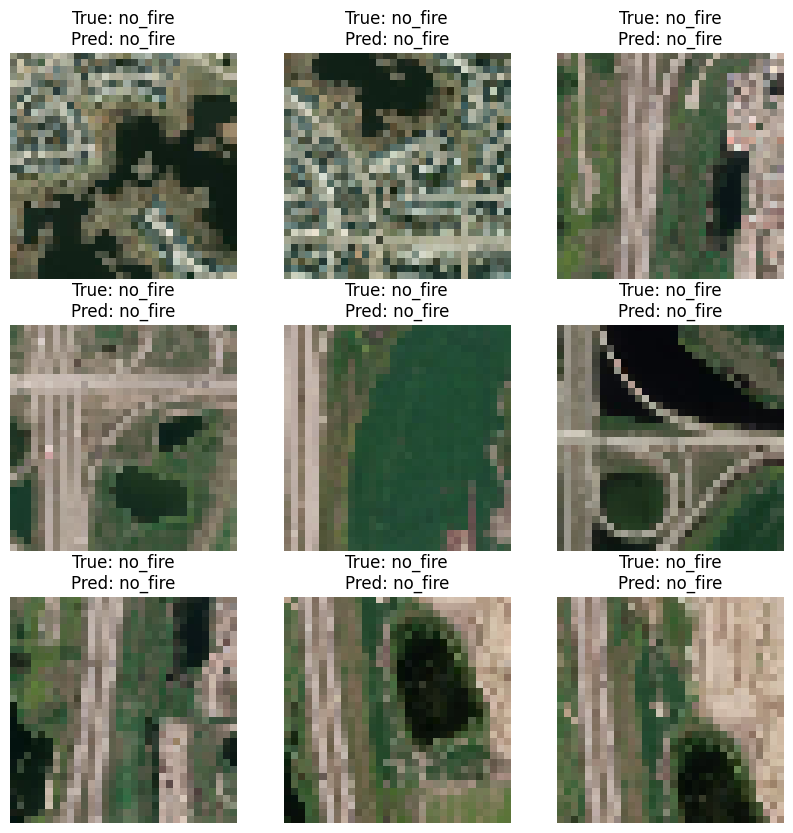

In [60]:
test_images, test_labels = next(test_generator)

pred_proba = model.predict(test_images)
pred_labels = (pred_proba > 0.5).astype(int).flatten()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.axis("off")
    true_label = "fire" if test_labels[i] == 1 else "no_fire"
    pred_label = "fire" if pred_labels[i] == 1 else "no_fire"
    plt.title(f"True: {true_label}\nPred: {pred_label}")
plt.show()
